<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Hands on Lab: Complete the Machine Learning Prediction lab


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [1]:
import piplite
await piplite.install(['numpy'])
await piplite.install(['pandas'])
await piplite.install(['seaborn'])

We will import the following libraries for the lab


In [2]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

<ipython-input-2-b7d446354769>:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


This function is to plot the confusion matrix.


In [121]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

## Load the dataframe


Load the data


In [155]:
from js import fetch
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = await fetch(URL1)
text1 = io.BytesIO((await resp1.arrayBuffer()).to_py())
data = pd.read_csv(text1)

In [156]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [157]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = await fetch(URL2)
text2 = io.BytesIO((await resp2.arrayBuffer()).to_py())
X = pd.read_csv(text2)

In [158]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [159]:
Y = data['Class'].to_numpy()
print(f"Type of Y:{type(Y)}")
Y

Type of Y:<class 'numpy.ndarray'>


array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [186]:
# students get this - Note from FA Morales, I don't think it's appropriate to scale the entire data set X since we are splitting later than this code block, 
# I will scale after the split using pipelines
# transform = preprocessing.StandardScaler()
# X = transform.fit_transform(X)

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [187]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

we can see we only have 18 test samples.


In [188]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [189]:
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=2))
])
parameters_reg = {"clf__C":[0.01,0.1,1], "clf__penalty":["l2"], "clf__solver":["lbfgs"]}

In [190]:
logreg_cv = GridSearchCV(
    estimator=lr,
    param_grid=parameters_reg,
    cv=10,
    scoring="accuracy",
    n_jobs=-1
)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=2))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1], 'clf__penalty': ['l2'],
                         'clf__solver': ['lbfgs']},
             scoring='accuracy')

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [191]:
print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hyperparameters :(best parameters)  {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
accuracy : 0.85


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [192]:
# Using the best estimator score against X_test and Y_test
test_accuracy = logreg_cv.best_estimator_.score(X_test, Y_test)
print(f"Score:{test_accuracy:.5f}")

Score:0.77778


Lets look at the confusion matrix:


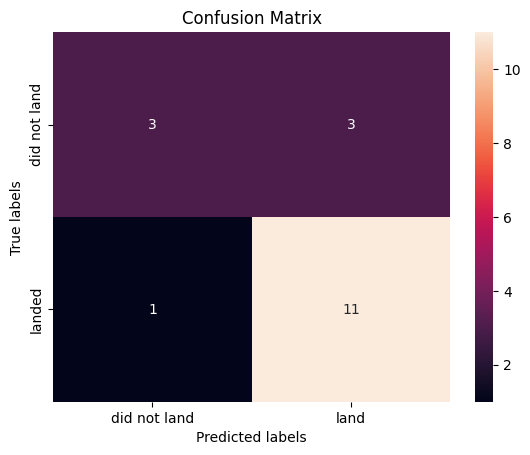

In [194]:
yhat_logreg =logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat_logreg)

### Overview:
Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the problem is false positives.
- TP (actual success, predicted success) = 11
- TN (actual fail, predicted fail) = 3
- FP (actual fail, predicted success) = 3
- FN (actual success, predicted fail) = 1

## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [195]:
svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(random_state=2))
])
parameters_svm = {'clf__kernel':('linear', 'rbf', 'poly', 'sigmoid'),
              'clf__C': np.logspace(-3, 3, 5),
              'clf__gamma':np.logspace(-3, 3, 5)}

In [196]:
svm_cv = GridSearchCV(
    estimator=svm,
    param_grid=parameters_svm,
    cv=10,
    scoring="accuracy",
    n_jobs=-1
)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', SVC(random_state=2))]),
             n_jobs=-1,
             param_grid={'clf__C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'clf__gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'clf__kernel': ('linear', 'rbf', 'poly', 'sigmoid')},
             scoring='accuracy')

In [197]:
print("tuned hyperparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hyperparameters :(best parameters)  {'clf__C': 0.03162277660168379, 'clf__gamma': 0.001, 'clf__kernel': 'linear'}
accuracy : 0.85


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [198]:
# Using the best estimator score against X_test and Y_test
test_accuracy_svc = svm_cv.best_estimator_.score(X_test, Y_test)
print(f"Score:{test_accuracy_svc:.5f}")

Score:0.77778


We can plot the confusion matrix


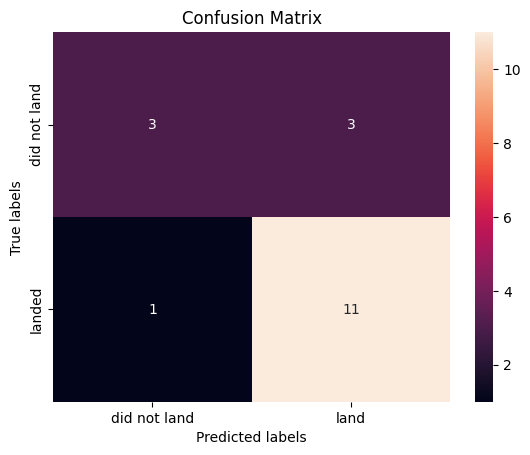

In [199]:
yhat_svm =svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat_svm)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [200]:
tree = DecisionTreeClassifier(random_state=2)
parameters_tree = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': [None, 'sqrt', 'log2'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

In [201]:
tree_cv = GridSearchCV(
    estimator=tree,
    param_grid=parameters_tree,
    cv=10,
    scoring="accuracy",
    n_jobs=-1
)
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=2), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [202]:
print("tuned hyperparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hyperparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.8928571428571429


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [203]:
# Using the best estimator score against X_test and Y_test
test_accuracy_tree = tree_cv.best_estimator_.score(X_test, Y_test)
print(f"Score:{test_accuracy_tree:.5f}")

Score:0.77778


We can plot the confusion matrix


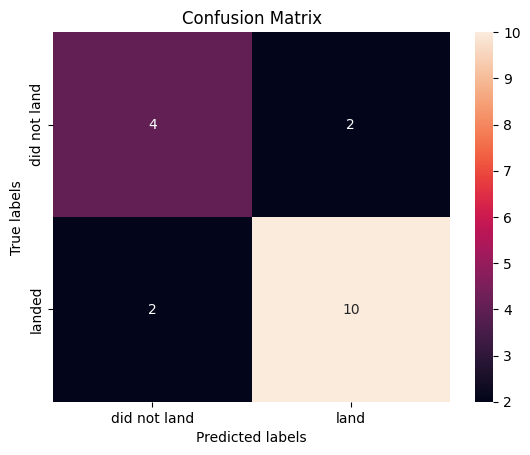

In [204]:
yhat_tree = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat_tree)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [205]:
KNN = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])
parameters_knn = {'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'clf__p': [1,2]}

In [211]:
knn_cv = GridSearchCV(
    estimator=KNN,
    param_grid=parameters_knn,
    cv=10,
    scoring="accuracy",
    n_jobs=-1
)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'clf__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'clf__p': [1, 2]},
             scoring='accuracy')

In [212]:
print("tuned hyperparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy:",knn_cv.best_score_)

tuned hyperparameters :(best parameters)  {'clf__algorithm': 'auto', 'clf__n_neighbors': 4, 'clf__p': 1}
accuracy: 0.8642857142857142


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [213]:
# Using the best estimator score against X_test and Y_test
test_accuracy_knn = knn_cv.best_estimator_.score(X_test, Y_test)
print(f"Score:{test_accuracy_knn:.5f}")

Score:0.77778


We can plot the confusion matrix


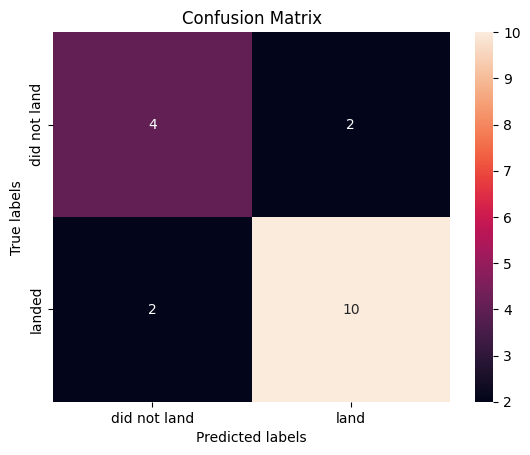

In [214]:
yhat_knn = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat_knn)

## TASK  12


### Comparing the different models
- I simplified the piplelines and generation of the grid searches for ease since scrolling was frustrating
- I then output the classification reports
- I ran into issues between the instructor's steps and my own so I spent some time identifying the delta and discovered issues with scaling the entire data frame and differences between scaling the training data holistically vs scaling in individual folds.   

In [215]:
# Pipelines (scale where needed)
pipe_lr  = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=1000, random_state=2))])
pipe_svm = Pipeline([("scaler", StandardScaler()), ("clf", SVC(random_state=2))])
pipe_knn = Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier())])
pipe_dt  = Pipeline([("clf", DecisionTreeClassifier(random_state=2))])

parameters_reg  = {"clf__C":[0.01,0.1,1], "clf__penalty":["l2"], "clf__solver":["lbfgs"]}
parameters_svm  = {"clf__kernel":("linear","rbf","poly","sigmoid"),
                   "clf__C": np.logspace(-3,3,5),
                   "clf__gamma": np.logspace(-3,3,5)}
parameters_tree = {"clf__criterion":["gini","entropy"],
                   "clf__splitter":["best","random"],
                   "clf__max_depth":[2*n for n in range(1,10)],
                   "clf__max_features":[None,"sqrt","log2"],
                   "clf__min_samples_leaf":[1,2,4],
                   "clf__min_samples_split":[2,5,10]}
parameters_knn  = {"clf__n_neighbors":[1,2,3,4,5,6,7,8,9,10],
                   "clf__algorithm":["auto","ball_tree","kd_tree","brute"],
                   "clf__p":[1,2]}

logreg_cv = GridSearchCV(pipe_lr,  parameters_reg,  cv=10, scoring="accuracy", n_jobs=-1).fit(X_train, Y_train)
svm_cv    = GridSearchCV(pipe_svm, parameters_svm,  cv=10, scoring="accuracy", n_jobs=-1).fit(X_train, Y_train)
tree_cv   = GridSearchCV(pipe_dt,  parameters_tree, cv=10, scoring="accuracy", n_jobs=-1).fit(X_train, Y_train)
knn_cv    = GridSearchCV(pipe_knn, parameters_knn, cv=10, scoring="accuracy", n_jobs=-1).fit(X_train, Y_train)                                                                                         

In [185]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def sanity(model, name):
    yhat = model.predict(X_test)
    print(f"\n{name}")
    print("Unique predictions:", np.unique(yhat, return_counts=True))
    print(classification_report(Y_test, yhat, digits=3))
    print("Confusion matrix:\n", confusion_matrix(Y_test, yhat))
    return yhat

yhat_logreg = sanity(logreg_cv, "LogReg")
yhat_svm    = sanity(svm_cv,    "SVM")
yhat_tree   = sanity(tree_cv,   "Decision Tree")
yhat_knn    = sanity(knn_cv,    "kNN")


LogReg
Unique predictions: (array([0, 1], dtype=int64), array([ 4, 14]))
              precision    recall  f1-score   support

           0      0.750     0.500     0.600         6
           1      0.786     0.917     0.846        12

    accuracy                          0.778        18
   macro avg      0.768     0.708     0.723        18
weighted avg      0.774     0.778     0.764        18

Confusion matrix:
 [[ 3  3]
 [ 1 11]]

SVM
Unique predictions: (array([0, 1], dtype=int64), array([ 4, 14]))
              precision    recall  f1-score   support

           0      0.750     0.500     0.600         6
           1      0.786     0.917     0.846        12

    accuracy                          0.778        18
   macro avg      0.768     0.708     0.723        18
weighted avg      0.774     0.778     0.764        18

Confusion matrix:
 [[ 3  3]
 [ 1 11]]

Decision Tree
Unique predictions: (array([0, 1], dtype=int64), array([ 6, 12]))
              precision    recall  f1-score 

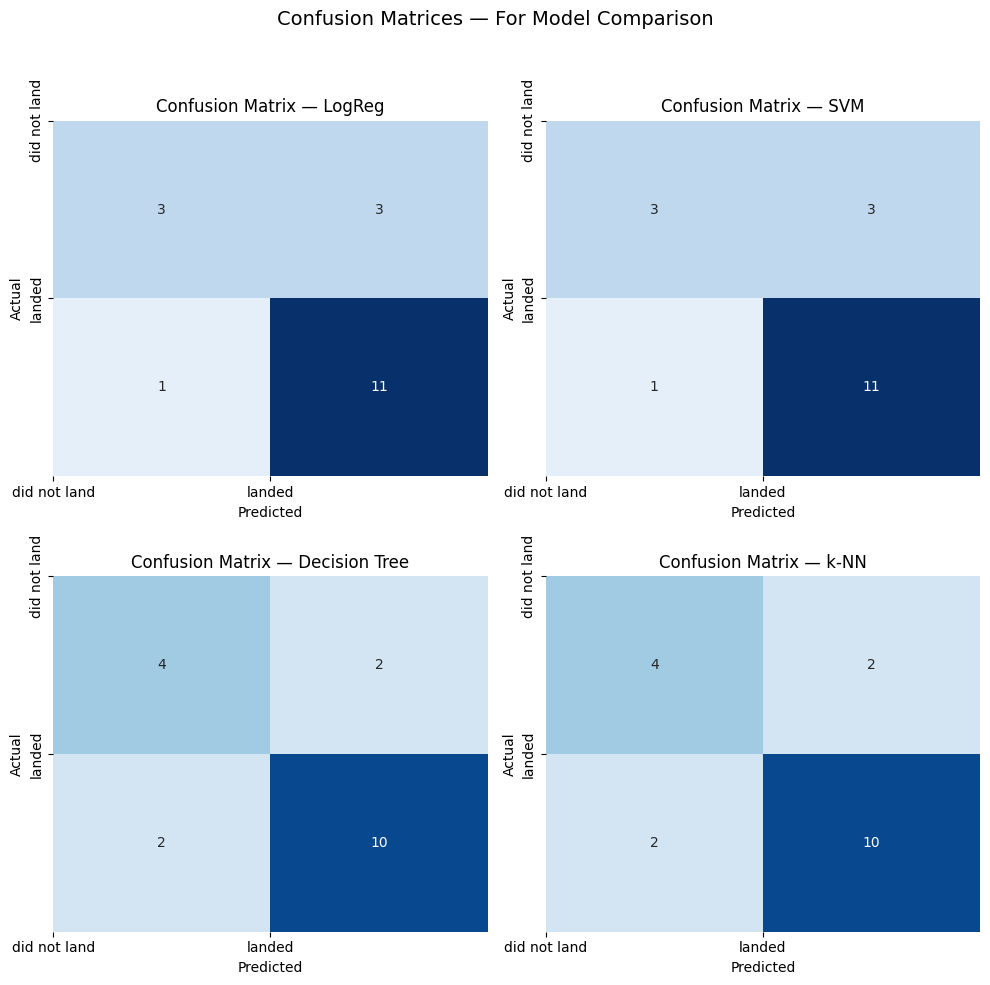

In [217]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, title,
            ax=None,
            normalize=None,                 # None | "true" | "pred" | "all"
            class_names=('did not land','landed'),
            cmap='Blues',
            vmin=None, vmax=None):
    """
    If ax is provided, draw into that axes (for grids).
    Otherwise, open a new figure (single plot behavior).
    """
    cm = confusion_matrix(y_true, y_pred, labels=[0,1], normalize=normalize)

    # formatting: raw counts or normalized
    fmt = "d" if normalize is None else ".2f"
    if ax is None:
        _, ax = plt.subplots(figsize=(4,3))

    sns.heatmap(cm, annot=True, fmt=fmt, cbar=False, ax=ax,
                cmap=cmap, vmin=vmin, vmax=vmax)

    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_title(title)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(class_names); ax.set_yticklabels(class_names)
    return cm  # return matrix in case you want to reuse it

pairs = [
    (yhat_logreg, "Confusion Matrix — LogReg"),
    (yhat_svm,    "Confusion Matrix — SVM"),
    (yhat_tree,   "Confusion Matrix — Decision Tree"),
    (yhat_knn,    "Confusion Matrix — k-NN"),
]

# (1) Compute all CMs first to share vmin/vmax (consistent colors)
cms = [confusion_matrix(Y_test, y, labels=[0,1]) for y, _ in pairs]
vmin, vmax = 0, max(cm.max() for cm in cms)  # use 0..max count across all

# (2) Plot in a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

for ax, ((yhat, title), cm) in zip(axes, zip(pairs, cms)):
    # Reuse the computed cm by passing vmin/vmax; plot_cm will recompute
    # the matrix internally, which is fine; or pass normalize="true" if preferred
    plot_cm(Y_test, yhat, title, ax=ax, normalize=None, vmin=vmin, vmax=vmax)

fig.suptitle("Confusion Matrices — For Model Comparison", y=0.98, fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Find the method performs best:

    model  test_accuracy   test_f1
0  LogReg       0.777778  0.846154
1     SVM       0.777778  0.846154
2    Tree       0.777778  0.833333
3     kNN       0.777778  0.833333

Best model by F1: LogReg  |  Accuracy=0.778, F1=0.846


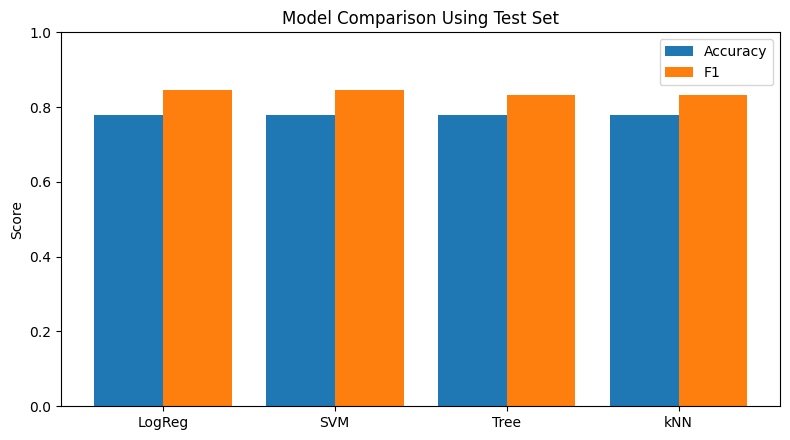

In [220]:
# Bar Chart comparing F1 and Test Accuracy

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

Xtest_for_all = X_test
models = {
    "LogReg": logreg_cv,
    "SVM":    svm_cv,
    "Tree":   tree_cv,
    "kNN":    knn_cv,
}

rows = []
for name, gs in models.items():
    est = gs.best_estimator_  # the tuned model
    yhat = est.predict(Xtest_for_all)

    # Accuracy & F1
    acc = accuracy_score(Y_test, yhat)
    f1  = f1_score(Y_test, yhat)

    rows.append({"model": name, "test_accuracy": acc, "test_f1": f1})

results_df = pd.DataFrame(rows).sort_values("test_f1", ascending=False)
print(results_df)

# Pick the "best" by F1
best = results_df.iloc[0]
print(f"\nBest model by F1: {best['model']}  |  "
      f"Accuracy={best['test_accuracy']:.3f}, F1={best['test_f1']:.3f}")

# === Grouped bar chart (Accuracy & F1) ===
labels = results_df["model"].tolist()
accs   = results_df["test_accuracy"].values
f1s    = results_df["test_f1"].values

x = np.arange(len(labels))
bar_w = 0.4

plt.figure(figsize=(8,4.5))
plt.bar(x - bar_w/2, accs, width=bar_w, label="Accuracy")
plt.bar(x + bar_w/2, f1s,  width=bar_w, label="F1")
plt.xticks(x, labels)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Model Comparison Using Test Set")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("model_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

### Determine the most Impactful Features for LogReg

In [222]:
from sklearn.inspection import permutation_importance

# Use Logreg_cv for determining the best features
best_gs = logreg_cv 
best_est = best_gs.best_estimator_    
Xtest_for_best = X_test                  

r = permutation_importance(
    best_est, Xtest_for_best, Y_test,
    n_repeats=30, random_state=42, scoring="f1"  # use the metric you care about
)

# Try to get feature names 
try:
    feature_names = best_est[:-1].get_feature_names_out()
except Exception:
    feature_names = getattr(X_test, "columns", np.arange(r.importances_mean.shape[0]).astype(str))

imp = (pd.DataFrame({
        "feature": feature_names,
        "importance_mean": r.importances_mean,
        "importance_std": r.importances_std
      })
      .sort_values("importance_mean", ascending=False))
print(imp.head(10))

           feature  importance_mean  importance_std
82       Legs_True         0.006154        0.015689
81      Legs_False         0.006154        0.015689
78   GridFins_True         0.006154        0.015689
77  GridFins_False         0.006154        0.015689
48    Serial_B1028         0.000000        0.000000
54    Serial_B1035         0.000000        0.000000
53    Serial_B1034         0.000000        0.000000
52    Serial_B1032         0.000000        0.000000
51    Serial_B1031         0.000000        0.000000
50    Serial_B1030         0.000000        0.000000


## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/)


<!--## Change Log--!>


<!--| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|--!>


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
